<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE</span></p>
<p><font size="4">  UE Numerical Methods </font></p>
<p></p>
<p><font size="5">  Lab - Array processing </font></p>
<p><font size="4">  By Kevin Michalewicz - 08/12/2021 </font></p>
</p></br>
</p>
</CENTER>

----------------------------

# Table of contents <a name="table-of-contents"></a>

1. [Source Localization](#Source-Localization)
2. [Beamforming](#Beamforming)

-----
        
# <span style="color:#00B8DE"> I - Source Localization</span><a name="Source-Localization)"></a>
    
[Table of contents](#table-of-contents)


>- 1- Simulate $T=400$ the contributions of two sources with pulsations $0°$ and $50°$, observed on ana array of $N=16$ sensors in the presence of a spatialy white noise, with $SNR=20dB$.
>- 2- Implement the periodogram spectrum estimator and observe it for 10 realizations. Plot the averaged periodogram. Influence of the number of sensors and of the SNR?
>- 3- Test the resolution of the periodogram (capacity to separate close sources) for $N=16,64$, by changing the pulsation of the second source. 
>- 4- Implement MUSIC algorithm and compare its resolution to that of the periodogram.
>- 5- Test the influence of the parameters (number of sensors, SNR, ...)

In [317]:
using Plots
using Statistics: mean
pyplot()

N    = 16 # 32 # 4 # 64
p    = 2
ϕ    = [0,50]*(π/180) 
T    = 400
SNR  = 20 # 80 # 0.0001 # changing this value wrt the original one
σ    = 10^(-SNR/20) # noise std
nb_points = 361 # this value was already chosen in the original code

#----------------
# Data generation
#----------------
data = exp.((0:N-1)im*ϕ') * (1/sqrt(2))*(randn(p,T)+randn(p,T)im) + (σ/sqrt(2))*(randn(N,T)+randn(N,T)im)     

#---------------------
# Periodogram
#---------------------
tf        = exp.(-(range(-π,stop=π,length=nb_points))im*(0:N-1)')
S_p       = (1/N)*(abs.(tf*data)).^2 # Fourier spectrum
S_p_moy   = mean(S_p,dims=2)

361×1 Matrix{Float64}:
 0.0419429416984555
 0.03211579139079611
 0.026362470604969036
 0.025066653715744746
 0.028261944045526115
 0.03563246023106389
 0.04654040520756333
 0.060078270721062726
 0.07514146574239447
 0.09051562761865206
 0.1049717935977978
 0.11736205623541754
 0.1267083376020606
 ⋮
 0.1331996802570813
 0.1421919116755964
 0.1467555265011306
 0.1465562133520758
 0.14163584158924994
 0.1324040373230927
 0.1196015958542508
 0.10423889285581746
 0.08751432056135584
 0.07071923590531352
 0.055136859526129234
 0.04194294169845559

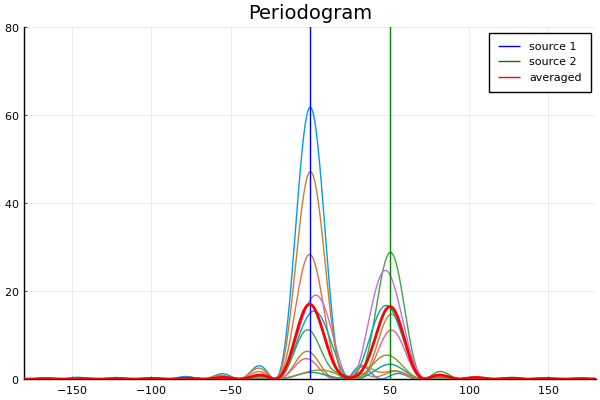

In [318]:
fig = plot()
for k=1:10
    fig =plot!(range(-180,stop=180,length=nb_points),S_p[:,k],label="")
end
max_per = maximum(S_p)
fig = plot!([ϕ[1],ϕ[1]]*(180/π),[0,max_per],c=:blue,label="source 1")
fig = plot!([ϕ[2],ϕ[2]]*(180/π),[0,max_per],c=:green,label="source 2")
fig = plot!(range(-180,stop=180,length=nb_points), xlims=(-180,180),ylims=(0,80),
            lw=2,c=:red, S_p_moy,label="averaged",title=("Periodogram"))


**Comment:** increasing $N$ we obtain higher peaks in $0°$ and $50°$. If this quantity is too low (for instance $N=4$) then the mean periodigram cannot be well-interpreted (i.e. there are no peaks in the correct places). Regarding the SNR, the peaks of the average plot do not tend to move. However, with a small $SNR$ the individual realizations will be more spread out along the horizontal axis (small peaks are seen).

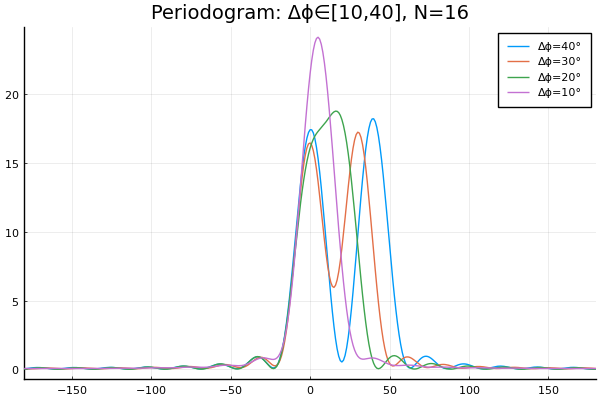

In [319]:
#------------------------------------------------
# Influence of second source location
# test for N=16,32,64
#------------------------------------------------
N         = 16 # 32 # 64
p         = 2
ϕ         = [0 50]*(π/180)
T         = 400
SNR       = 20
σ         = 10^(-SNR/20) # noise std

fig = plot()
for k=1:4
    Δϕ = ϕ - [0 10*k]*(π/180)
    data    = exp.((0:N-1)im*Δϕ) * (1/sqrt(2))*(randn(p,T)+randn(p,T)im) + (σ/sqrt(2))*(randn(N,T)+randn(N,T)im)     
    tf      = exp.(-(range(-π,stop=π,length=nb_points))im*(0:N-1)')
    S_p     = (1/N)*(abs.(tf*data)).^2 # Fourier spectrum
    S_p_moy = mean(S_p,dims=2)
    fig     = plot!(range(-180,stop=180,length=nb_points),S_p_moy,label="Δϕ=$(50-10*k)°")
end
plot!(fig, xlims=(-180,180), title="Periodogram: Δϕ∈[10,40], N=$N")

**Comment:** with $N=16$ sources can be well distinguished if $Δϕ \geq 30°$ (taking into the account the values form the previous plot). In the $N=32$ it still fails to do it for $Δϕ = 10°$. If $N$ is increased to $64$ the resolution (capacity to separate close sources) increases, as it can manage well all the considered $Δϕ$ values. 

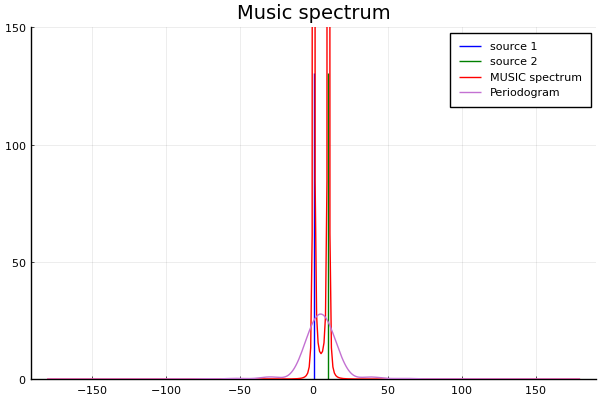

In [320]:
#----------------
# MUSIC algorithm
#----------------
using LinearAlgebra: eigen, norm
#----------------
# Main parameters
#----------------
N         = 16 # 8 # 32 # 128
p         = 2
ϕ         = [0,10]*(π/180)
T         = 400
SNR  = 20 # 40 # # 10 # 0 # 0.0001 
σ    = 10^(-SNR/20) # noise std

#----------------
# Data generation
#----------------
data    = exp.((0:N-1)im*ϕ') * (1/sqrt(2))*(randn(p,T)+randn(p,T)im) + (σ/sqrt(2))*(randn(N,T)+randn(N,T)im)     

#----------------------
# Localization function
#----------------------

R = (1/T)*data*data'
U = eigen(R).vectors[:,1:N-p]
g   = (1 ./ sum(abs.(U'*exp.(collect(0:N-1)im*collect(range(-pi,stop=pi,length=nb_points))')).^2,dims=1))'

fig = plot()
fig = plot!([ϕ[1],ϕ[1]]*(180/π),[0,max_per],c=:blue,label="source 1")
fig = plot!([ϕ[2],ϕ[2]]*(180/π),[0,max_per],c=:green,label="source 2")
fig = plot!(range(-180,stop=180,length=nb_points),g,c=:red,ylims=(0,150), label="MUSIC spectrum",title="Music spectrum")
# periodogram
tf        = exp.(-(range(-π,stop=π,length=nb_points))im*(0:N-1)')
S_p       = (1/N)*(abs.(tf*data)).^2 # Fourier spectrum
S_p_moy   = mean(S_p,dims=2)
fig     = plot!(range(-180,stop=180,length=nb_points),S_p_moy,label="Periodogram")


**Comment:** for the same original $SNR$ and $N$ the MUSIC algorithm has a better resolution than the periodogram. For lower values of $N$ MUSIC acquires higher amplitudes but peaks at $0°$ and $10°$ can be noticed by changing *ylims*. For $N=128$ both algorithms succeed in recognizing the sources, but the periodogram presents more fluctuations. The peaks height increase as well, in the MUSIC case, with the $SNR$.

# <span style="color:#00B8DE"> II - Beamforming</span><a name="Beamforming"></a>
    
[Table of contents](#table-of-contents)


## <span style="color:#00B8DE"> 1 - data independent beamforming</span>


Consider the output of  beamformer: ${\bf h}^H{\bf r}_t = s_{1,t} [{\bf h}^H{\bf d}(\phi_1)] + {\bf h}^H{\bf b}_t.$

Two terms appear: a useful one and a second one that involves noise and interference. We are going to look for a beamformer that preserves the amplitude of the signal impinging from the direction of interest, that is, ${\bf h}^H{\bf d}(\phi_1)=1$. 

**6)** Provided the condition ${\bf h}^H{\bf d}(\phi_1)=1$ is satisfied, check that minimizing the power of the useless term ${\bf h}^H{\bf b}_t$ amounts to minimize the total power of the beamformer output.

**7)** Thus we get a constrained optimization problem and give its solution, denoted by $\bf{h}_{MV}$.



The goal of this lab is to achieve beamforming using a linear array of $N$ equispaced sensors.
$\Delta$ will denote the distance between successive sensors,
$(s_{k,t})_{k=1,p}$ the $p$ signals received on the first sensor at time $t$ from remote transmitters. The noise received on sensors is denoted by ${\bf w}_t =[w_{1,t},\ldots,w_{N,t}]^T$ and the vector of observed complex signal by ${\bf r}_t$.

Signals are asumed narrowband, that is, their bandwidth is much smaller than their central frequency. Letting 
$\theta_k$ denote the angle of the signal impinging from source $k$, measured relatively to the normal to the sensors array and $f$ the central frequency of signals the resulting phase shift for this signal between successive sensors will be dented by $\phi_k$.

We consider $N=6$ sensors and $p=2$ sources in respective directions $0°$ and $30°$.

**1)** What is the expression of $\phi_k$ as a function of $f$, $\Delta$, $\theta_k$ and of propagation speed $c$.

------------

#### Answer 

$$ϕ_k = \frac{2 π f Δ sin(θ_k)}{c} $$

-------------

Observation ${\bf r}_t$ is expressed as 

\begin{equation}
{\bf r}_t = \sum_{k=1,p} s_{k,t}\; {\bf d}(\phi_k) +  {\bf w}_t,
\end{equation}

where ${\bf d}(\phi_k)=[1,e^{i\phi_k},e^{2i\phi_k},\ldots,e^{(N-1)i\phi_k}]^T$
is often called the *steering vector* of source $k$.

We want to estimate a source signal, say $s_1(t)$, assuming that its direction is known. Contributions of other signals and noise are summerized in a vector denoted by ${\bf b}_t$ that represent the set of undesired contributions with respect to $s_{1,t}$~:

\begin{equation}
{\bf r}_t =  s_{1,t} {\bf d}(\phi_1) + (\sum_{k=2,p} s_{k,t} {\bf
  d}(\phi_k) +  {\bf w}_t) = s_{1,t} {\bf d}(\phi_1) + {\bf b}_t.
\end{equation}

Beamforming aims at realizing a linear combination of the entries of observation vector ${\bf r}_t$ 
so as to get an estimate $\hat{s}_1(t)$ of $s_1(t)$. In a vector form, beamforming is described by a weighing vector ${\bf h}=[{\bf h}_1,\ldots,{\bf h}_n]^T$ such that

\begin{equation}
\hat{s}_{1,t} = \sum_{n=1,N}{\bf h}_n^*{\bf r}_{t,n} = {\bf h}^H{\bf r}_t.
\end{equation}

**2)** Give the expression of the beamforming vector ${\bf h}$ that performs phase correction of the useful part of the received signal vector. We shall denote by ${\bf h}_{PR}$ (PR: Phase Recovery) this beamforming. 

------------

### Answer 

$${\bf h}_{PR}= {\bf d}(\phi_1)$$

According to slide number 14 of the *Introduction to array processing* presentation:

$${\bf G}_{PR} = \frac{SNR_{PR}}{SNR_0} = \frac{Tr({\bf R_b})}{Tr({\bf \Pi R_b})}$$

with ${\bf \Pi}= {\bf d}(\phi_1){\bf d}(\phi_1)^H/\parallel {\bf d}(\phi_1)\parallel^2$ 

------------

**3)** Complete the code supplied to achieve the beamforming. Plot estimated $s_{1,t}$ and the array pattern of the antenna. in the code, observation is formed by contribution of both sources and noise. 
What do you observe?

In [321]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [322]:
N     = 6;                  # number of sensors
ϕ     = (π/180)*[0,30]      # phase of sources
T     = 1000                # number of observation vectors
SNR   = 1                   # signal o noise ratio
σ     = 10^(-SNR/20)        # noise std (signals power = 1)

# Signals generation
#-------------------
s = hcat(sign.(sin.(2π*0.01*(1:T))), sqrt(2)*cos.(2π*0.005*(1:T)))'
data  = exp.((0:N-1)im*ϕ') * s + (σ/sqrt(2))*(randn(N,T)+randn(N,T)im);

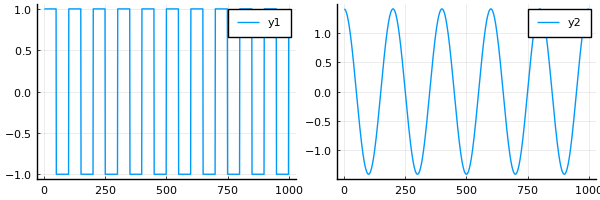

In [323]:
plot(s',size=(600,200),layout=(1,2))

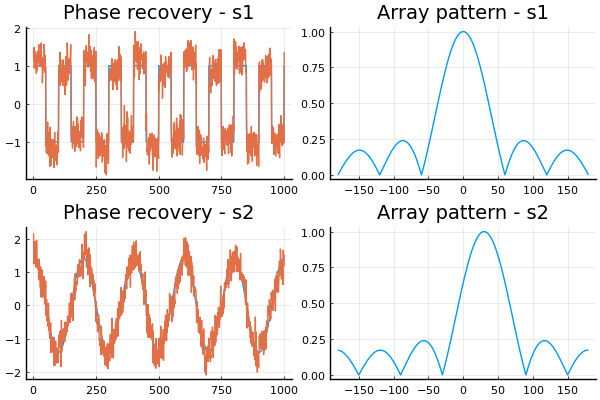

In [324]:
# Beamformer based on phase correction
#--------------------------------------

φ = range(-π,π,length=nb_points)

# Beamformer source 1
h_PR = (1/N)*exp.((0:N-1)im*ϕ[1]) # beamforming vector h
Z_PR = h_PR'*data   
s1_PR = plot([s[1,:], real.(Z_PR)'], title="Phase recovery - s1", label="")
s1_array = plot(φ*180/π, abs.(h_PR'*exp.((0:N-1)im*φ'))', title="Array pattern - s1", label="")

# Beamformer source 2
h_PR = (1/N)*exp.((0:N-1)im*ϕ[2]) # beamforming vector h
Z_PR = h_PR'*data  
s2_PR = plot([s[2,:], real.(Z_PR)'], title="Phase recovery - s2",label="")
s2_array = plot(φ*180/π, abs.(h_PR'*exp.((0:N-1)im*φ'))', title="Array pattern - s2", label="")

plot(s1_PR,s1_array,s2_PR,s2_array,layout=(2,2))

**Comment (was already in the notebook):** We observe that source signals are well reconstructed but that there is some interference between sources because beamformers do not cancel in the direction of the undesired source.

**4)** Compute the array pattern as a function of the the number of sensors. Comments?

**5)** For white spatial noise plot the evolution of the SINR for the first source at the array output as a function of the number of sensors. Conclusion? 

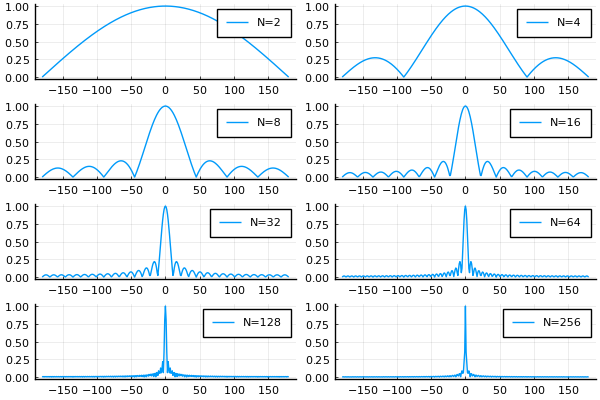

In [325]:
dd = Dict()
SINR_PR = zeros(8)

for N_val=1:8
    N = 2^N_val
    data = exp.((0:N-1)im*ϕ') * s + σ * randn(N,T)               
    h_PR = (1/N)*exp.((0:N-1)im*ϕ[1])  
    Z_PR = (h_PR'*data)'         
    diagram = (abs.(h_PR'*exp.(((0:N-1)im*φ'))))'
    dd["AP$N_val"] = plot((180/π)*φ,diagram,label="N=$N")
    SINR_PR[N_val] = sum(s[1,:].^2)/real((s[1,:] .- Z_PR)'*(s[1,:] .- Z_PR))[1]
end

plot(dd["AP1"],dd["AP2"],dd["AP3"],dd["AP4"],dd["AP5"],dd["AP6"],dd["AP7"],dd["AP8"],layout=(4,2))

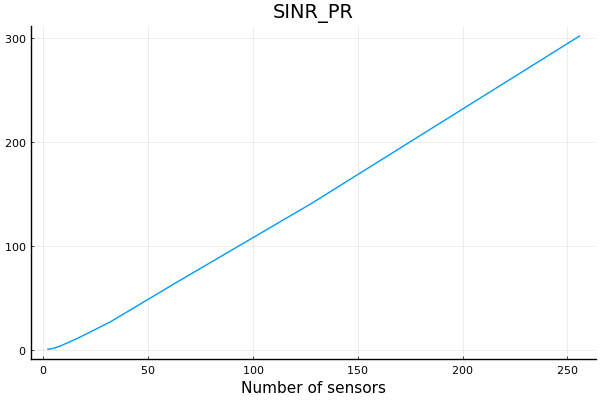

In [326]:
plot([2^j for j=1:8], SINR_PR, title="SINR_PR", xlabel="Number of sensors", legend=false)

## <span style="color:#00B8DE"> 2 - Minimum variance beamforming</span>

Consider the output of  beamformer: ${\bf h}^H{\bf r}_t = s_{1,t} [{\bf h}^H{\bf d}(\phi_1)] + {\bf h}^H{\bf b}_t.$

Two terms appear: a useful one and a second one that involves noise and interference. We are going to look for a beamformer that preserves the amplitude of the signal impinging from the direction of interest, that is, ${\bf h}^H{\bf d}(\phi_1)=1$. 

**6)** Provided the condition ${\bf h}^H{\bf d}(\phi_1)=1$ is satisfied, check that minimizing the power of the useless term ${\bf h}^H{\bf b}_t$ amounts to minimize the total power of the beamformer output.

**7)** Thus we get a constrained optimization problem and give its solution, denoted by $\bf{h}_{MV}$.

**8)** Implement this beamformer and compare the ouputs of sources signal recovery twith that of $\bf{h}_{PR}$

**9)** Plot array functions for both beamforms and compare their capability of rejecting the interfering source. 

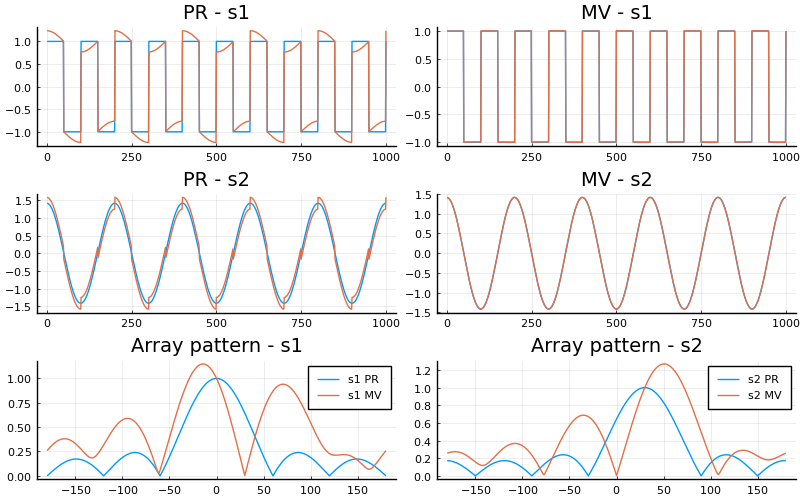

In [327]:
# Beamformer based on phase correction
#--------------------------------------

N     = 6                   # number of sensors
ϕ     = (π/180)*[0,30]      # phase of sources
T     = 10^3                # number of observation vectors
SNR   = 50 # 1              # signal to noise ratio
σ     = 10^(-SNR/20)        # noise std (signals power = 1)

s = hcat(sign.(sin.(2π*0.01*(1:T))), sqrt(2)*cos.(2π*0.005*(1:T)))'
data  = exp.((0:N-1)im*ϕ') * s + (σ/sqrt(2))*(randn(N,T)+randn(N,T)im)

φ = range(-π,π,length=nb_points)
μ = mean(data,dims=2)
Ry_inv = inv((1/T)*data*data'-μ*μ' + 10^(-3)*diagm(0=>ones(N)))  

# Beamformer source 1
h_PR = (1/N)*exp.((0:N-1)im*ϕ[1]) # beamforming vector h
Z_PR = h_PR'*data   
s1_PR = plot([s[1,:], real.(Z_PR)'], title="PR - s1", label="")

vec = Ry_inv*exp.((0:N-1)im*ϕ[1])
h_MV = vec/(exp.((0:N-1)im*ϕ[1])'*vec)
Z_MV = h_MV'*data
s1_MV = plot([s[1,:], real.(Z_MV)'], title="MV - s1", label="")

s1_array = plot(φ*180/π, abs.(h_PR'*exp.((0:N-1)im*φ'))', title="Array pattern - s1", label="s1 PR")
s1_array = plot!(φ*180/π, abs.(h_MV'*exp.((0:N-1)im*φ'))', label="s1 MV")

# Beamformer source 2
h_PR = (1/N)*exp.((0:N-1)im*ϕ[2]) # beamforming vector h
Z_PR = h_PR'*data  
s2_PR = plot([s[2,:], real.(Z_PR)'], title="PR - s2",label="")

vec = Ry_inv*exp.((0:N-1)im*ϕ[2])
h_MV = vec/(exp.((0:N-1)im*ϕ[2])'*vec)
Z_MV = h_MV'*data
s2_MV = plot([s[2,:], real.(Z_MV)'], title="MV - s2", label="")

s2_array = plot(φ*180/π, abs.(h_PR'*exp.((0:N-1)im*φ'))', title="Array pattern - s2", label="s2 PR")
s2_array = plot!(φ*180/π, abs.(h_MV'*exp.((0:N-1)im*φ'))', label="s2 MV")

plot(s1_PR,s1_MV,s2_PR,s2_MV,s1_array,s2_array,layout=(3,2),size=(800,500))

**Comment:** at high SNR the MV solution fits well the signals, but the PR one acts as if it had been high-pass filtered.